# Session 10 - Unsupervised Learning 

## Contents

- [Principal Components Analysis](#Principal-Components-Analysis)
- [Clustering Methods](#Clustering-Methods)

In [1]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

The difference between *supervised learning* and *unsupervised learning* is that in the first case we have a variable $y$ which we want to predict, given a set of variables $\{ X_1, . . . , X_p \}$.

In *unsupervised learning* are not interested in prediction, because we do not have an associated response variable $y$. Rather, the goal is to discover interesting things about the measurements on $\{ X_1, . . . , X_p \}$. Question that we can answer are:

- Is there an informative way to visualize the data? 
- Can we discover subgroups among the variables or among the observations?

We are going to answe these questions with two main methods, respectively:

- Principal Components Analysis
- Clustering

## Principal Component Analysis

Suppose that we wish to visualize $n$ observations with measurements on a set of $p$ features, $\{X_1, . . . , X_p\}$, as part of an exploratory data analysis.

We could do this by examining two-dimensional scatterplots of the data, each of which contains the n observations’ measurements on two of the features. However, there are $p(p−1)/2$ such scatterplots; for example,
with $p = 10$ there are $45$ plots! 

PCA provides a tool to do just this. It finds a low-dimensional represen- tation of a data set that contains as much as possible of the variation. 

The **first principal component** of a set of features $\{X_1, . . . , X_p\}$ is the normalized linear combination of the features

$$
Z_1 = \phi_{11} X_1 + \phi_{21} X_2 + ... + \phi_{p1} X_p
$$

that has the largest variance. By normalized, we mean that $\sum_{i=1}^p \phi^2_{i1} = 1$.

In other words, the first principal component loading vector solves the op- timization problem

$$
\underset{\phi_{11}, \ldots, \phi_{p 1}}{\operatorname{max}} \ \left\{\frac{1}{n} \sum_{i=1}^{n}\left(\sum_{j=1}^{p} \phi_{j 1} x_{i j}\right)^{2}\right\} \quad \text { subject to } \quad \sum_{j=1}^{p} \phi_{j 1}^{2}=1
$$

The objective that we are maximizing is just the sample variance of the $n$ values of $z_{i1}$.

After the first principal component $Z_1$ of the features has been determined, we can find the second principal component $Z_2$. The **second principal component** is the linear combination of $\{X_1, . . . , X_p\}$ that has maximal variance out of all linear combinations that are *uncorrelated* with $Z_1$.


We illustrate the use of PCA on the `USArrests` data set. For each of the 50 states in the United States, the data set contains the number of arrests per $100,000$ residents for each of three crimes: `Assault`, `Murder`, and `Rape.` We also record the percent of the population in each state living in urban areas, `UrbanPop`.

In [3]:
# Load crime data
df = pd.read_csv('data/USArrests.csv', index_col=0)
df.head()

,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [4]:
# Scale data
X_scaled = pd.DataFrame(scale(df), index=df.index, columns=df.columns).values

In [5]:
# Fit PCA with 2 components
pca2 = PCA(n_components=2).fit(X_scaled)

In [6]:
# Get loadings
loadings = pca2.components_.T
df_loadings = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])
df_loadings

,PC1,PC2
Murder,0.535899,0.418181
Assault,0.583184,0.187986
UrbanPop,0.278191,-0.872806
Rape,0.543432,-0.167319


In [7]:
# Transform X to get the principal components
X_dim2 = pca2.transform(X_scaled)
df_dim2 = pd.DataFrame(X_dim2, columns=['PC1', 'PC2'], index=df.index)
df_dim2.head()

,PC1,PC2
State,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


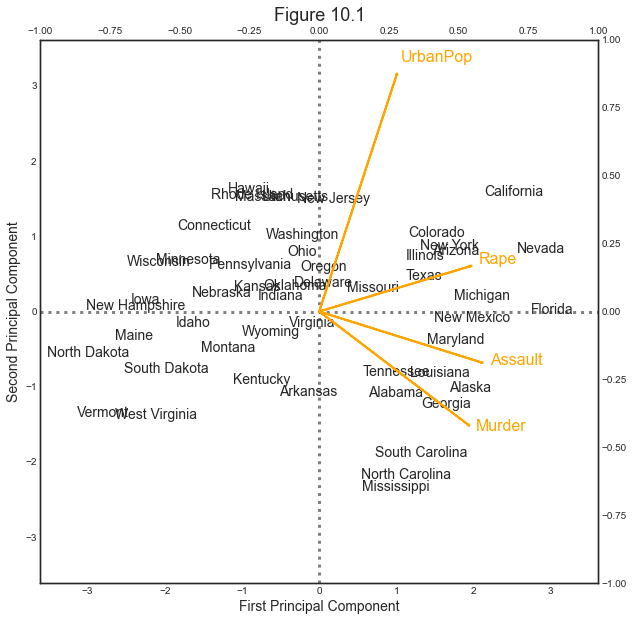

In [8]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_title('Figure 10.1');

# Plot Principal Components 1 and 2
for i in df_dim2.index:
    ax1.annotate(i, (df_dim2.PC1.loc[i], -df_dim2.PC2.loc[i]), ha='center', fontsize=14)
    
# Plot reference lines
m = np.max(np.abs(df_dim2.values))*1.2
ax1.hlines(0,-m,m, linestyles='dotted', colors='grey')
ax1.vlines(0,-m,m, linestyles='dotted', colors='grey')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.set_xlim(-m,m); ax1.set_ylim(-m,m)

# Plot Principal Component loading vectors, using a second y-axis.
ax1b = ax1.twinx().twiny() 
ax1b.set_ylim(-1,1); ax1b.set_xlim(-1,1)
for i in df_loadings[['PC1', 'PC2']].index:
    ax1b.annotate(i, (df_loadings.PC1.loc[i]*1.05, -df_loadings.PC2.loc[i]*1.05), color='orange', fontsize=16)
    ax1b.arrow(0,0,df_loadings.PC1[i], -df_loadings.PC2[i], color='orange', lw=2)

### More on PCA

#### Scaling the Variables

The results obtained when we perform PCA will also depend on whether the variables have been individually scaled. In fact, the variance of a variable depends on its magnitude.

In [13]:
# Variables variance
df.var(axis=0)

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Consequently, if we perform PCA on the unscaled variables, then the first principal component loading vector will have a very large loading for `Assault`, since that variable has by far the highest variance.

In [14]:
# Fit PCA with unscaled varaibles
X = df.values
pca2_u = PCA(n_components=2).fit(X)

In [15]:
# Get loadings
loadings_u = pca2_u.components_.T
df_loadings_u = pd.DataFrame(loadings_u, index=df.columns, columns=['PC1', 'PC2'])
df_loadings_u

,PC1,PC2
Murder,0.041704,0.044822
Assault,0.995221,0.058760
UrbanPop,0.046336,-0.976857
Rape,0.075156,-0.200718


In [16]:
# Transform X to get the principal components
X_dim2_u = pca2_u.transform(X)
df_dim2_u = pd.DataFrame(X_dim2_u, columns=['PC1', 'PC2'], index=df.index)
df_dim2_u.head()

,PC1,PC2
State,,
Alabama,64.802164,11.448007
Alaska,92.827450,17.982943
Arizona,124.068216,-8.830403
Arkansas,18.340035,16.703911
California,107.422953,-22.520070


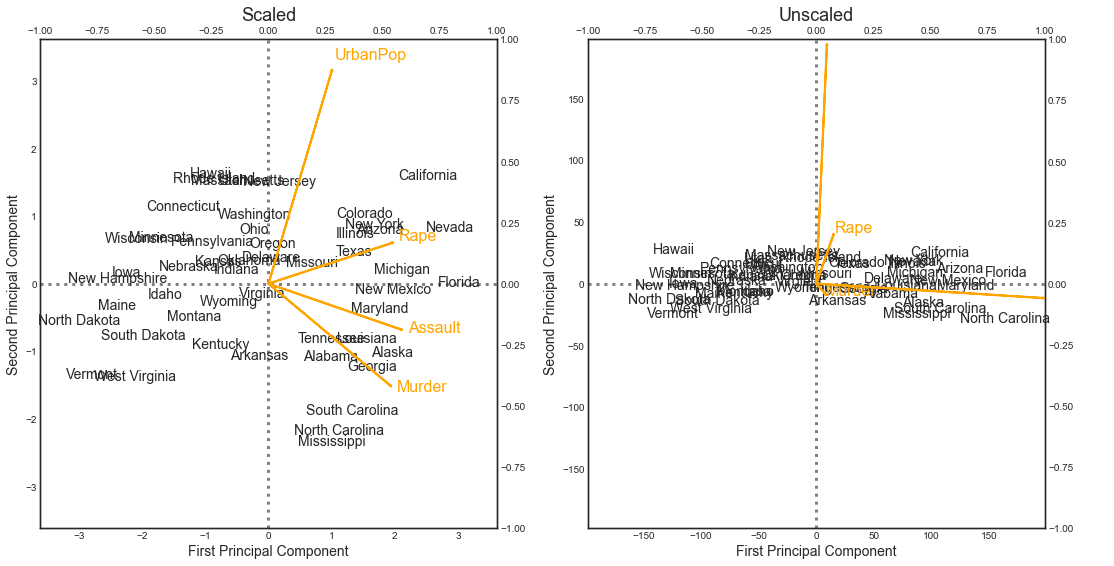

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,9))

# Scaled PCA
for i in df_dim2.index:
    ax1.annotate(i, (df_dim2.PC1.loc[i], -df_dim2.PC2.loc[i]), ha='center', fontsize=14)
ax1b = ax1.twinx().twiny() 
ax1b.set_ylim(-1,1); ax1b.set_xlim(-1,1)
for i in df_loadings[['PC1', 'PC2']].index:
    ax1b.annotate(i, (df_loadings.PC1.loc[i]*1.05, -df_loadings.PC2.loc[i]*1.05), color='orange', fontsize=16)
    ax1b.arrow(0,0,df_loadings.PC1[i], -df_loadings.PC2[i], color='orange', lw=2)
ax1.set_title('Scaled')
    
# Unscaled PCA
for i in df_dim2_u.index:
    ax2.annotate(i, (df_dim2_u.PC1.loc[i], -df_dim2_u.PC2.loc[i]), ha='center', fontsize=14)
ax2b = ax2.twinx().twiny() 
ax2b.set_ylim(-1,1); ax2b.set_xlim(-1,1)
for i in df_loadings_u[['PC1', 'PC2']].index:
    ax2b.annotate(i, (df_loadings_u.PC1.loc[i]*1.05, -df_loadings_u.PC2.loc[i]*1.05), color='orange', fontsize=16)
    ax2b.arrow(0,0,df_loadings_u.PC1[i], -df_loadings_u.PC2[i], color='orange', lw=2)
ax2.set_title('Unscaled')

# Plot reference lines
for ax,df in zip((ax1,ax2), (df_dim2,df_dim2_u)):
    m = np.max(np.abs(df.values))*1.2
    ax.hlines(0,-m,m, linestyles='dotted', colors='grey')
    ax.vlines(0,-m,m, linestyles='dotted', colors='grey')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_xlim(-m,m); ax.set_ylim(-m,m)

As predicted, the first principal component loading vector places almost all of its weight on `Assault`, while the second principal component loading vector places almost all of its weight on `UrpanPop`. Comparing this to the left-hand plot, we see that scaling does indeed have a substantial effect on the results obtained. However, this result is simply a consequence of the scales on which the variables were measured. 

#### The Proportion of Variance Explained

In general, a $n \times p$ data matrix $X$ has $\min\{n − 1, p\}$ distinct principal components. However, we usually are not interested in all of them; rather, we would like to use just the first few principal components in order to visualize or interpret the data. 

We typically decide on the number of principal components required to visualize the data by examining a *scree plot*.

In [99]:
# Four components
pca4 = PCA(n_components=4).fit(X_scaled)

In [100]:
# Variance of the four principal components
pca4.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [101]:
# As a percentage of the total variance
pca4.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

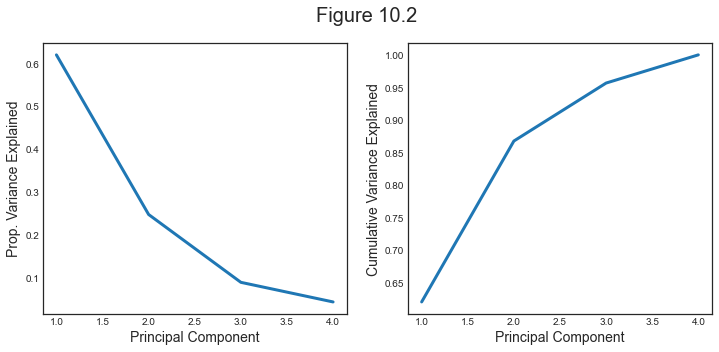

In [104]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 10.2');

# Relative 
ax1.plot([1,2,3,4], pca4.explained_variance_ratio_)
ax1.set_ylabel('Prop. Variance Explained')
ax1.set_xlabel('Principal Component');

# Cumulative
ax2.plot([1,2,3,4], np.cumsum(pca4.explained_variance_ratio_))
ax2.set_ylabel('Cumulative Variance Explained');
ax2.set_xlabel('Principal Component');

#### Deciding How Many Principal Components to Use

## Clustering

### K-Means Clustering

The `sklearn` function `Kmeans()` performs K-means clustering in R. We begin with
a simple simulated example in which there truly are two clusters in the
data: the first 25 observations have a mean shift relative to the next 25
observations.

Text(0, 0.5, 'X1')

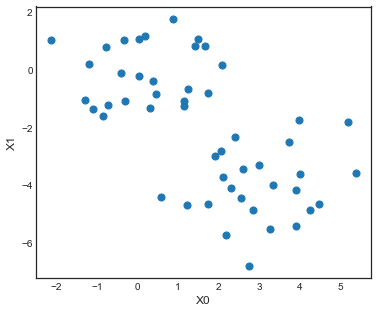

In [14]:
np.random.seed(123)
X = np.random.randn(50,2)
X[0:25, 0] = X[0:25, 0] + 3
X[0:25, 1] = X[0:25, 1] - 4

f, ax = plt.subplots(figsize=(6, 5))
ax.scatter(X[:,0], X[:,1], s=50) 
ax.set_xlabel('X0')
ax.set_ylabel('X1')

We now perform K-means clustering with `K = 2`:

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, random_state = 123).fit(X)

The cluster assignments of the 50 observations are contained in
`kmeans.labels_`:

In [16]:
print(kmeans.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


The K-means clustering perfectly separated the observations into two clusters
even though we did not supply any group information to `Kmeans()`. We
can plot the data, with each observation colored according to its cluster
assignment:

Text(0, 0.5, 'X1')

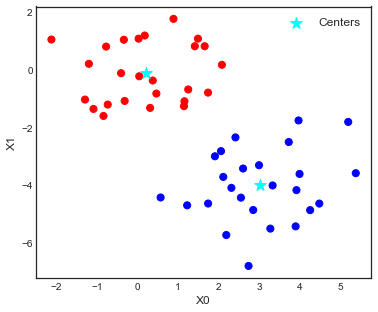

In [17]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s = 50, c = kmeans.labels_, cmap = plt.cm.bwr) 
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            marker = '*', 
            s = 150,
            color = 'cyan', 
            label = 'Centers')
plt.legend(loc = 'best')
plt.xlabel('X0')
plt.ylabel('X1')

Here the observations can be easily plotted because they are two-dimensional.
If there were more than two variables then we could instead perform PCA
and plot the first two principal components score vectors.

In this example, we knew that there really were two clusters because
we generated the data. However, for real data, in general we do not know
the true number of clusters. We could instead have performed K-means
clustering on this example with `K  =  3`. If we do this, K-means clustering will split up the two "real" clusters, since it has no information about them:

Text(0, 0.5, 'X1')

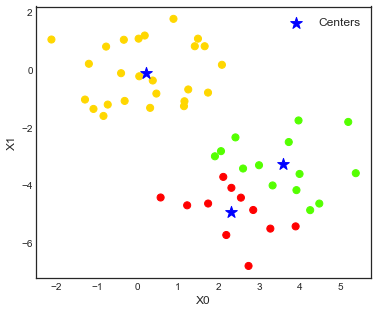

In [18]:
kmeans_3_clusters = KMeans(n_clusters = 3, random_state = 123)
kmeans_3_clusters.fit(X)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=50, c=kmeans_3_clusters.labels_, cmap=plt.cm.prism) 
plt.scatter(kmeans_3_clusters.cluster_centers_[:, 0], kmeans_3_clusters.cluster_centers_[:, 1], marker='*', s=150,
            color='blue', label='Centers')
plt.legend(loc='best')
plt.xlabel('X0')
plt.ylabel('X1')

To run the `Kmeans()` function in python with multiple initial cluster assignments,
we use the `n_init` argument (default: 10). If a value of `n_init` greater than one
is used, then K-means clustering will be performed using multiple random
assignments, and the `Kmeans()` function will
report only the best results. Here we compare using `n_init = 1`:

In [19]:
km_out_single_run = KMeans(n_clusters = 3, n_init = 1, random_state = 123).fit(X)
km_out_single_run.inertia_

99.66252501749231

to `n_init = 20`:

In [20]:
km_out_single_run = KMeans(n_clusters = 3, n_init = 20, random_state = 123).fit(X)
km_out_single_run.inertia_

98.83395271281782

Note that `.inertia_` is the total within-cluster sum of squares,
which we seek to minimize by performing K-means clustering.

It is generally recommended to always run K-means clustering with a large
value of `n_init`, such as 20 or 50 to avoid getting stuck in an undesirable local
optimum.

When performing K-means clustering, in addition to using multiple initial
cluster assignments, it is also important to set a random seed using the
`random_state` parameter. This way, the initial cluster assignments can
be replicated, and the K-means output will be fully reproducible.

### Hierarchical Clustering

The `linkage()` function from `scipy` implements several clustering functions in python. In the following example we use the data from the previous section to plot the hierarchical
clustering dendrogram using complete, single, and average linkage clustering,
with Euclidean distance as the dissimilarity measure. We begin by
clustering observations using complete linkage:

In [21]:
from scipy.cluster.hierarchy import linkage

hc_complete = linkage(X, "complete")

We could just as easily perform hierarchical clustering with average or single linkage instead:

In [22]:
hc_average = linkage(X, "average")
hc_single = linkage(X, "single")

We can now plot the dendrograms obtained using the usual `dendrogram()` function.
The numbers at the bottom of the plot identify each observation:

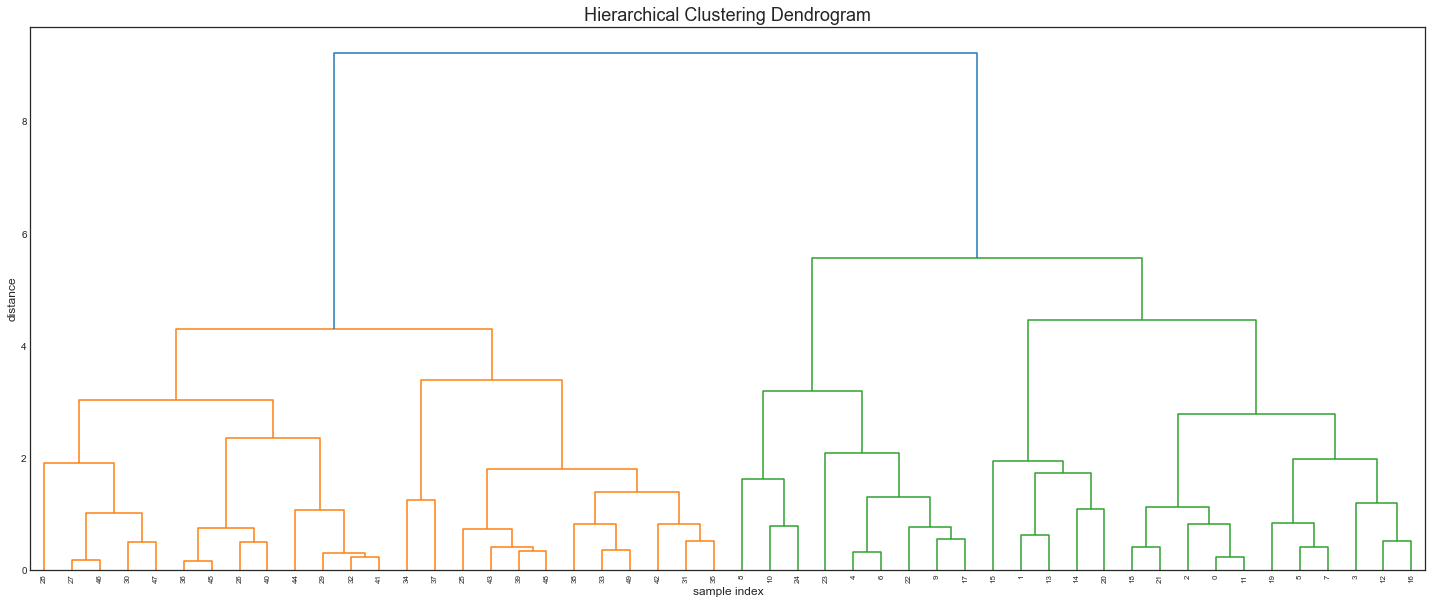

In [23]:
from scipy.cluster.hierarchy import dendrogram

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    hc_complete,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

To determine the cluster labels for each observation associated with a
given cut of the dendrogram, we can use the `cut_tree()` function:

In [24]:
from scipy.cluster.hierarchy import cut_tree
print(cut_tree(hc_complete, n_clusters = 2).T) # Printing transpose just for space

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


For this data, complete and average linkage generally separates the observations
into their correct groups.